# Regridding the WOA13 onto the ASTE grid

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Get the datasets

### WOA13 climatology

In [2]:
woa_dir = '/local/data/artemis/workspace/rdussin/Observations/WOA13/originals/'
#woa_no3_ds = xr.open_mfdataset(woa_dir + 'woa13_all_n*.nc', decode_times=False)
#woa_po4_ds = xr.open_mfdataset(woa_dir + 'woa13_all_p*.nc', decode_times=False)
#woa_o2_ds = xr.open_mfdataset(woa_dir + 'woa13_all_o*.nc', decode_times=False)

woa_ts_ds = xr.open_mfdataset(woa_dir + 'woa13_decav*.nc', decode_times=False)

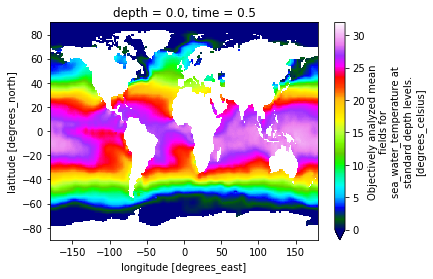

In [18]:
woa_ts_ds['t_an'].isel(time=0, depth=0).plot(vmin=0, vmax=32, cmap='gist_ncar')

In [7]:
#woa_ts_ds

### ASTE raw grid

In [4]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

### ASTE output grid

In [5]:
datadir_aste = '/local/data/artemis/workspace/rdussin/ASTE/RUNS/ASTE-Phy-Release1/outputs/'
md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste_out = xmitgcm.open_mdsdataset(datadir_aste, iters=[], prefix=['T','S','Eta','U','V'],
                                   geometry='llc', nx=270, extra_metadata=md)

In [10]:
WOA_drowned_T = xr.Dataset()
drowned_temp = MITgcm_recipes.regridding.drown_field(woa_ts_ds, 't_an', 
                                                     dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)

drowned_salt = MITgcm_recipes.regridding.drown_field(woa_ts_ds, 's_an', 
                                                     dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)

WOA_drowned_T.update({'t_an': drowned_temp['t_an'],
                      's_an': drowned_salt['s_an']})

<xarray.Dataset>
Dimensions:  (depth: 57, lat: 180, lon: 360, time: 12)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * depth    (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * time     (time) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
Data variables:
    t_an     (time, depth, lat, lon) float64 -0.3322 -0.3873 -0.3923 -0.4043 ...
    s_an     (time, depth, lat, lon) float64 34.21 34.2 34.19 34.18 34.17 ...

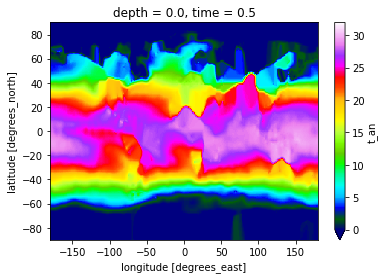

In [17]:
WOA_drowned_T['t_an'].isel(time=0, depth=0).plot(vmin=0, vmax=32, cmap='gist_ncar')

## Vertical interpolation

In [11]:
# nitrate
#woa_no3_dsz = MITgcm_recipes.vertical_interpolation(woa_no3_ds, aste_out['Z'], ['n_an'],
#                                                    lonvar='lon', latvar='lat',
#                                                    depth_varin='depth',
#                                                    timevar='time')

# phosphate
#woa_po4_dsz = MITgcm_recipes.vertical_interpolation(woa_po4_ds, aste_out['Z'], ['p_an'],
#                                                    lonvar='lon', latvar='lat',
#                                                    depth_varin='depth',
#                                                    timevar='time')

# oxygen
#woa_o2_dsz = MITgcm_recipes.vertical_interpolation(woa_o2_ds, aste_out['Z'], ['o_an'],
#                                                   lonvar='lon', latvar='lat',
#                                                   depth_varin='depth',
#                                                   timevar='time')

# T/S
woa_ts_dsz = MITgcm_recipes.vertical_interpolation(WOA_drowned_T, aste_out['Z'], ['t_an', 's_an'],
                                                   lonvar='lon', latvar='lat',
                                                   depth_varin='depth',
                                                   timevar='time')

In [13]:
woa_ts_dsz

<xarray.Dataset>
Dimensions:  (k: 50, lat: 180, lon: 360, time: 12)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * time     (time) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
    drF      (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    PHrefC   (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
Data variables:
    Z        (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    t_an     (time, k, lat, lon) float64 -0.3158 -0.3708 -0.3782 -0.3952 ...
    s_an     (time, k, lat, lon) float64 34.21 34.2 34.19 34.18 34.17 34.16 ...

## Regridding

The mld fields are not gonna be used to force the model so no extrapolation is needed.
Those are 2d fields so no vertical interpolation either

In [14]:
#woa_no3_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(woa_no3_dsz, aste_raw, ['n_an'], 
#                                                             method='bilinear',
#                                                             lonname='lon', latname='lat', point='T', 
#                                                             periodic=True, reuse_weights=False,
#                                                             regridname='woa03_1deg_aste_face')

#woa_po4_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(woa_po4_dsz, aste_raw, ['p_an'], 
#                                                             method='bilinear',
#                                                             lonname='lon', latname='lat', point='T', 
#                                                             periodic=True, reuse_weights=True,
#                                                             regridname='woa03_1deg_aste_face')

#woa_o2_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(woa_o2_dsz, aste_raw, ['o_an'], 
#                                                            method='bilinear',
#                                                            lonname='lon', latname='lat', point='T', 
#                                                            periodic=True, reuse_weights=True,
#                                                            regridname='woa03_1deg_aste_face')

woa_ts_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(woa_ts_dsz, aste_raw, ['t_an', 's_an'], 
                                                            method='bilinear',
                                                            lonname='lon', latname='lat', point='T', 
                                                            periodic=True, reuse_weights=True,
                                                            regridname='woa03_1deg_aste_face')

Create weight file: woa03_1deg_aste_face0.nc
Create weight file: woa03_1deg_aste_face1.nc
Create weight file: woa03_1deg_aste_face2.nc
Create weight file: woa03_1deg_aste_face3.nc
Create weight file: woa03_1deg_aste_face4.nc
Create weight file: woa03_1deg_aste_face5.nc


## Checking the results

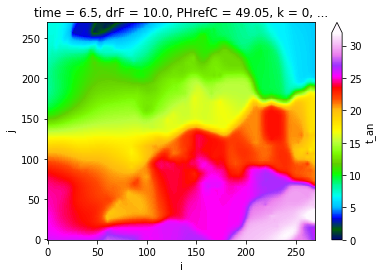

In [20]:
woa_ts_aste['t_an'].isel(face=1, time=6, k=0).plot(vmin=0, vmax=32, cmap='gist_ncar')

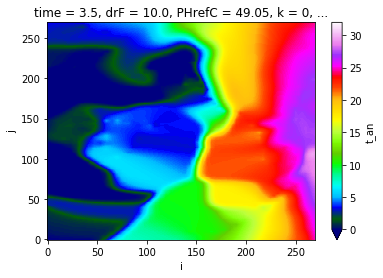

In [22]:
woa_ts_aste['t_an'].isel(face=4, time=3, k=0).plot(vmin=0, vmax=32, cmap='gist_ncar')

In [26]:
masked_woa_ts_aste = MITgcm_recipes.regridding.mask_output_zeros(woa_ts_aste, 
                                                                 aste_out, 
                                                                 point='T')

In [27]:
masked_woa_ts_aste

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, j: 270, k: 50, time: 12)
Coordinates:
  * time     (time) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
    drF      (k) >f4 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.01 10.03 10.11 ...
    PHrefC   (k) >f4 49.05 147.15 245.25 343.35 441.45 539.55 637.65 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5
    XC       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    YC       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    CS       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    SN       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    Z        (k) >f4 dask.array<shape=(50,), chunksize=(50,

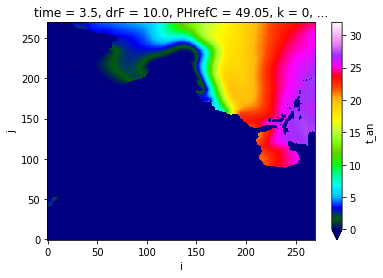

In [28]:
masked_woa_ts_aste['t_an'].isel(face=4, time=3, k=0).plot(vmin=0, vmax=32, cmap='gist_ncar')

## Write to binary files

In [31]:
# temperature
facets = xmitgcm.utils.rebuild_llc_facets(masked_woa_ts_aste['t_an'].isel(time=0), md)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', md)
xmitgcm.utils.write_to_binary(compact, 'T_WOA13_Jan_ASTE.bin', precision='double')

In [32]:
# salinity
facets = xmitgcm.utils.rebuild_llc_facets(masked_woa_ts_aste['s_an'].isel(time=0), md)
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z', md)
xmitgcm.utils.write_to_binary(compact, 'S_WOA13_Jan_ASTE.bin', precision='double')